# Predicción de Series Temporales NN - Multivariate

## Usaremos Keras y Tensorflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


### Cargamos nuestro Dataset

In [2]:
df = pd.read_csv('Prueba_Value.csv', parse_dates=[0], header=None, index_col=0, names=['fecha','ventas'])
df.head()

,ventas
fecha,
2018-04-04,233288.5
2018-04-05,46377.7
2018-04-06,119753.5
2018-04-07,382697.7
2018-04-08,379653.0


In [3]:
print(df.index.min())
print(df.index.max())

2018-04-04 00:00:00
2019-06-21 00:00:00


In [4]:
print(len(df['2018']))
print(len(df['2019']))

241
170


### Cargamos Datos Categóricos: Día y Mes

In [5]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,ventas,weekday,month
fecha,,,
2018-04-04,233288.5,2,4
2018-04-05,46377.7,3,4
2018-04-06,119753.5,4,4
2018-04-07,382697.7,5,4
2018-04-08,379653.0,6,4


In [6]:
df.describe()

,ventas,weekday,month
count,4.110000e+02,411.000000,411.000000
mean,2.565328e+06,2.963504,6.148418
std,5.466110e+06,1.994170,3.242231
min,1.500000e+02,0.000000,1.000000
25%,4.106673e+05,1.000000,4.000000
50%,1.097674e+06,3.000000,6.000000
75%,2.347434e+06,5.000000,9.000000
max,4.551789e+07,6.000000,12.000000


## Preprocesado de los datos

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
PASOS=7

# load dataset
values = df['ventas'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('ventas',axis=1)
#print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2018-04-11,2.0,4.0,-0.989756,3.0,4.0,-0.997969,4.0,4.0,-0.994745,5.0,...,-0.983325,0.0,4.0,-0.973275,1.0,4.0,-0.974256,2,4,-0.982001
2018-04-12,3.0,4.0,-0.997969,4.0,4.0,-0.994745,5.0,4.0,-0.983191,6.0,...,-0.973275,1.0,4.0,-0.974256,2.0,4.0,-0.982001,3,4,-0.979665
2018-04-13,4.0,4.0,-0.994745,5.0,4.0,-0.983191,6.0,4.0,-0.983325,0.0,...,-0.974256,2.0,4.0,-0.982001,3.0,4.0,-0.979665,4,4,-0.973850
2018-04-14,5.0,4.0,-0.983191,6.0,4.0,-0.983325,0.0,4.0,-0.973275,1.0,...,-0.982001,3.0,4.0,-0.979665,4.0,4.0,-0.973850,5,4,-0.972389
2018-04-15,6.0,4.0,-0.983325,0.0,4.0,-0.973275,1.0,4.0,-0.974256,2.0,...,-0.979665,4.0,4.0,-0.973850,5.0,4.0,-0.972389,6,4,-0.973864


## Dividimos en set de Entrenamiento y Validación

In [9]:
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(404, 22)


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2018-04-11,2.0,4.0,-0.989756,3.0,4.0,-0.997969,4.0,4.0,-0.994745,5.0,...,6.0,4.0,-0.983325,0.0,4.0,-0.973275,1.0,4.0,-0.974256,-0.982001
2018-04-12,3.0,4.0,-0.997969,4.0,4.0,-0.994745,5.0,4.0,-0.983191,6.0,...,0.0,4.0,-0.973275,1.0,4.0,-0.974256,2.0,4.0,-0.982001,-0.979665
2018-04-13,4.0,4.0,-0.994745,5.0,4.0,-0.983191,6.0,4.0,-0.983325,0.0,...,1.0,4.0,-0.974256,2.0,4.0,-0.982001,3.0,4.0,-0.979665,-0.973850
2018-04-14,5.0,4.0,-0.983191,6.0,4.0,-0.983325,0.0,4.0,-0.973275,1.0,...,2.0,4.0,-0.982001,3.0,4.0,-0.979665,4.0,4.0,-0.973850,-0.972389
2018-04-15,6.0,4.0,-0.983325,0.0,4.0,-0.973275,1.0,4.0,-0.974256,2.0,...,3.0,4.0,-0.979665,4.0,4.0,-0.973850,5.0,4.0,-0.972389,-0.973864


In [10]:
# split into train and test sets
values = newReframed.values
n_train_days = 405 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(368, 1, 21) (368,) (36, 1, 21) (36,)


# Creamos el Modelo de Red Neuronal

## Utilizaremos una Red Feedforward

#### Como entradas son 21 columnas (7 pasos por 3 variables)

In [11]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

## Entrenamiento y Resultados

In [12]:
# En pocos segundos vemos una reducción del valor de pérdida tanto del set de entrenamiento como del de validación. 
# original EPOCHS = 40, luego voy modificando
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

W0826 01:27:49.250577 10296 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 01:27:49.393315 10296 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 01:27:49.407318 10296 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 01:27:49.671342 10296 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 7)              154       
_________________________________________________________________
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________


W0826 01:27:50.467514 10296 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0826 01:27:50.906163 10296 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 368 samples, validate on 36 samples
Epoch 1/40
368/368 [==============================] - 6s 15ms/step - loss: 0.1959 - mean_squared_error: 0.1315 - val_loss: 0.1352 - val_mean_squared_error: 0.0379
Epoch 2/40
368/368 [==============================] - 1s 2ms/step - loss: 0.1109 - mean_squared_error: 0.0738 - val_loss: 0.1451 - val_mean_squared_error: 0.0413
Epoch 3/40
368/368 [==============================] - 1s 2ms/step - loss: 0.1032 - mean_squared_error: 0.0714 - val_loss: 0.1484 - val_mean_squared_error: 0.0424
Epoch 4/40
368/368 [==============================] - 1s 2ms/step - loss: 0.1015 - mean_squared_error: 0.0709 - val_loss: 0.1506 - val_mean_squared_error: 0.0430
Epoch 5/40
368/368 [==============================] - 1s 2ms/step - loss: 0.1006 - mean_squared_error: 0.0704 - val_loss: 0.1504 - val_mean_squared_error: 0.0430
Epoch 6/40
368/368 [==============================] - 1s 2ms/step - loss: 0.0998 - mean_squared_error: 0.0703 - val_loss: 0.1500 - val_mean_squa

## Visualizamos Resultados

36


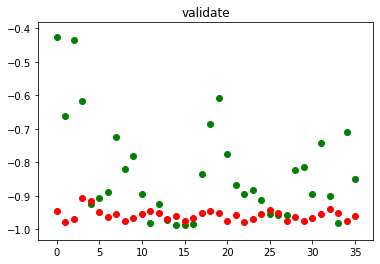

In [13]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

En la gráfica vemos que los puntitos verdes intentan aproximarse a los rojos. Cuanto más cerca ó superpuestos mejor. TIP: Si aumentamos la cantidad de EPOCHS mejora cada vez más.

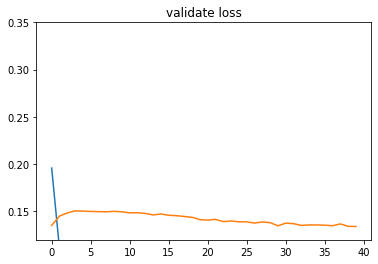

In [14]:
plt.ylim(0.12, 0.35)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

Modelo 2) STMV: En azul el Entrenamiento y naranja el set de Validación

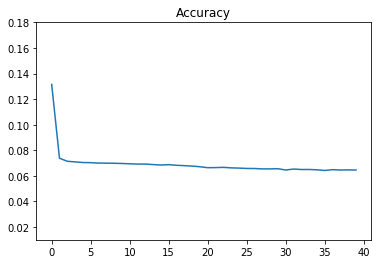

In [15]:
plt.ylim(0.01, 0.18)
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [16]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,1.307995e+07,1.221433e+06,1.185852e+07
1,7.676430e+06,4.896655e+05,7.186764e+06
2,1.286241e+07,7.218526e+05,1.214056e+07
3,8.711175e+06,2.099330e+06,6.611844e+06
4,1.744367e+06,1.939718e+06,-1.953504e+05
5,2.109401e+06,1.181956e+06,9.274449e+05
6,2.551606e+06,8.616543e+05,1.689951e+06
7,6.291698e+06,1.028242e+06,5.263456e+06
8,4.080572e+06,5.773234e+05,3.503248e+06
9,4.978848e+06,7.790441e+05,4.199804e+06


In [17]:
compara2.describe()

,real,prediccion,diferencia
count,3.600000e+01,3.600000e+01,3.600000e+01
mean,3.817181e+06,9.581260e+05,2.859055e+06
std,3.320769e+06,3.655223e+05,3.314275e+06
min,2.701904e+05,4.896655e+05,-7.569421e+05
25%,1.537273e+06,7.163627e+05,3.289223e+05
50%,2.619419e+06,9.327516e+05,1.940135e+06
75%,5.321472e+06,1.104721e+06,4.633486e+06
max,1.307995e+07,2.099330e+06,1.214056e+07


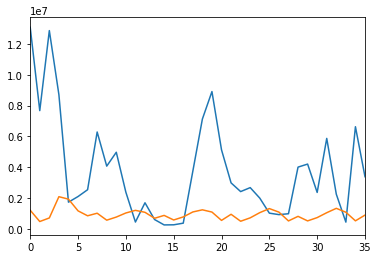

In [18]:
compara2['real'].plot()
compara2['prediccion'].plot()

# Pronóstico

In [19]:
ultimosDias = df['2019-05-16':'2019-05-31']
ultimosDias

,ventas,weekday,month,scaled
fecha,,,,
2019-05-16,24630096.36,3,5,0.082213
2019-05-17,13079948.65,4,5,-0.425288
2019-05-18,7676430.50,5,5,-0.662713
2019-05-19,12862411.06,6,5,-0.434846
2019-05-20,8711173.60,0,5,-0.617247
2019-05-21,1744367.82,1,5,-0.923361
2019-05-22,2109401.84,2,5,-0.907322
2019-05-23,2551605.95,3,5,-0.887892
2019-05-24,6291698.19,4,5,-0.723556


## Preparamos los datos para Test

Y ahora seguiremos el mismo preprocesado de datos que hicimos para el entrenamiento: escalando los valores, llamando a la función series_to_supervised pero esta vez sin incluir la columna de salida «Y» pues es la que queremos hallar. Por eso, verán en el código que hacemos drop() de la última columna.

In [20]:
scaledMerge=ultimosDias.drop('ventas',axis=1)
print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
newReframed.head(7)

[[ 3.          5.          0.08221316]
 [ 4.          5.         -0.42528778]
 [ 5.          5.         -0.66271257]
 [ 6.          5.         -0.43484616]
 [ 0.          5.         -0.61724699]
 [ 1.          5.         -0.92336094]
 [ 2.          5.         -0.90732175]
 [ 3.          5.         -0.88789177]
 [ 4.          5.         -0.72355616]
 [ 5.          5.         -0.82071066]
 [ 6.          5.         -0.78124136]
 [ 0.          5.         -0.8949033 ]
 [ 1.          5.         -0.97992617]
 [ 2.          5.         -0.92507106]
 [ 3.          5.         -0.97279352]
 [ 4.          5.         -0.98813468]]


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1)
fecha,,,,,,,,,,,,,,,,,,,,,
2019-05-23,3.0,5.0,0.082213,4.0,5.0,-0.425288,5.0,5.0,-0.662713,6.0,...,-0.434846,0.0,5.0,-0.617247,1.0,5.0,-0.923361,2.0,5.0,-0.907322
2019-05-24,4.0,5.0,-0.425288,5.0,5.0,-0.662713,6.0,5.0,-0.434846,0.0,...,-0.617247,1.0,5.0,-0.923361,2.0,5.0,-0.907322,3.0,5.0,-0.887892
2019-05-25,5.0,5.0,-0.662713,6.0,5.0,-0.434846,0.0,5.0,-0.617247,1.0,...,-0.923361,2.0,5.0,-0.907322,3.0,5.0,-0.887892,4.0,5.0,-0.723556
2019-05-26,6.0,5.0,-0.434846,0.0,5.0,-0.617247,1.0,5.0,-0.923361,2.0,...,-0.907322,3.0,5.0,-0.887892,4.0,5.0,-0.723556,5.0,5.0,-0.820711
2019-05-27,0.0,5.0,-0.617247,1.0,5.0,-0.923361,2.0,5.0,-0.907322,3.0,...,-0.887892,4.0,5.0,-0.723556,5.0,5.0,-0.820711,6.0,5.0,-0.781241
2019-05-28,1.0,5.0,-0.923361,2.0,5.0,-0.907322,3.0,5.0,-0.887892,4.0,...,-0.723556,5.0,5.0,-0.820711,6.0,5.0,-0.781241,0.0,5.0,-0.894903
2019-05-29,2.0,5.0,-0.907322,3.0,5.0,-0.887892,4.0,5.0,-0.723556,5.0,...,-0.820711,6.0,5.0,-0.781241,0.0,5.0,-0.894903,1.0,5.0,-0.979926


De este conjunto «ultimosDias» tomamos sólo la última fila, pues es la que correspondería a la última semana de Mayo y la dejamos en el formato correcto para la red neuronal con reshape:

In [21]:
values = newReframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = newReframed.index[len(newReframed.index)-1].weekday()

(3, 1, 21)
[[[ 2.          5.         -0.90732175  3.          5.
   -0.88789177  4.          5.         -0.72355616  5.
    5.         -0.82071066  6.          5.         -0.78124136
    0.          5.         -0.8949033   1.          5.
   -0.97992617]]

 [[ 3.          5.         -0.88789177  4.          5.
   -0.72355616  5.          5.         -0.82071066  6.
    5.         -0.78124136  0.          5.         -0.8949033
    1.          5.         -0.97992617  2.          5.
   -0.92507106]]

 [[ 4.          5.         -0.72355616  5.          5.
   -0.82071066  6.          5.         -0.78124136  0.
    5.         -0.8949033   1.          5.         -0.97992617
    2.          5.         -0.92507106  3.          5.
   -0.97279352]]]


Ahora crearemos una función para ir «rellenando» el desplazamiento que hacemos por cada predicción. Esto es porque queremos predecir los 7 primeros días de Junio. Entonces para el 1 de Junio, ya tenemos el set con los últimos 7 días de Mayo. Pero para pronosticar el 2 de Junio necesitamos los 7 días anteriores que INCLUYEN al 1 de Junio y ese valor, lo obtenemos en nuestra predicción anterior. Y así hasta el 7 de Junio.

In [22]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
    x_test[0][0][x_test.shape[2]-2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

## Pronóstico para la "próxima semana"

In [23]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[ 2.          5.         -0.90732175  3.          5.
   -0.88789177  4.          5.         -0.72355616  5.
    5.         -0.82071066  6.          5.         -0.78124136
    0.          5.         -0.8949033   1.          5.
   -0.97992617]]

 [[ 3.          5.         -0.88789177  4.          5.
   -0.72355616  5.          5.         -0.82071066  6.
    5.         -0.78124136  0.          5.         -0.8949033
    1.          5.         -0.97992617  2.          5.
   -0.92507106]]

 [[ 4.          5.         -0.72355616  5.          5.
   -0.82071066  6.          5.         -0.78124136  0.
    5.         -0.8949033   1.          5.         -0.97992617
    2.          5.         -0.92507106  3.          5.
   -0.97279352]]]
pred 1 [[[ 3.          5.         -0.88789177  4.          5.
   -0.72355616  5.          5.         -0.82071066  6.
    5.         -0.78124136  0.          5.         -0.8949033
    1.          5.         -0.97992617  5.         12.
   -0.95224702]]

 [[ 

## Re-Convertimos los resultados

Ya casi lo tenemos… Ahora las predicciones están en el dominio del -1 al 1 y nosotros lo queremos en nuestra escala «real» de ventas vendidas. Entonces vamos a «re-transformar» los datos con el objeto «scaler» que creamos antes.

In [24]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.952247], dtype=float32), array([-0.7964507], dtype=float32), array([-0.94741267], dtype=float32), array([-0.9386809], dtype=float32), array([-0.7664847], dtype=float32), array([-0.966152], dtype=float32), array([-0.95191956], dtype=float32)]


array([[1086952.94872832],
       [4632701.63209876],
       [1196977.37590475],
       [1395702.86765281],
       [5314693.8234662 ],
       [ 770491.13232892],
       [1094405.74815263]])

## Visualizamos el pronóstico

Ya podemos crear un nuevo DataFrame Pandas por si quisiéramos guardar un nuevo csv con el pronóstico. Y lo visualizamos.

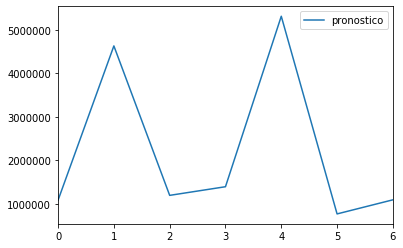

In [25]:
prediccion1SemanaJunio = pd.DataFrame(inverted)
prediccion1SemanaJunio.columns = ['pronostico']
prediccion1SemanaJunio.plot()
prediccion1SemanaJunio.to_csv('pronostico_multivariate_V.csv')

In [26]:
prediccion1SemanaJunio

,pronostico
0,1.086953e+06
1,4.632702e+06
2,1.196977e+06
3,1.395703e+06
4,5.314694e+06
5,7.704911e+05
6,1.094406e+06


A partir de los últimos 7 días de Mayo 2019 y utilizando nuestra red neuronal, hicimos el siguiente pronóstico de venta de ventas para la primer semana de Junio.

Para Probar, alterando parámetros del ejercicio:

Variar la cantidad de EPOCHS Probar otro optimizador distinto a Adam, ó configurar valores distintos de Learning Rate. Cambiar la arquitectura de la Red Neuronal: Cambiar la cantidad de Neuronas de la capa oculta. Agregar más capas ocultas Probar utilizando más de 7 días previos para predecir. O probar con menos días. Se puede intentar predecir más de 1 día por vez (sin iterar el resultado como hice con la función agregarNuevoValor() )

## Agregamos el resultado en el dataset

In [27]:
i=0
for fila in prediccion1SemanaJunio.pronostico:
    i=i+1
    ultimosDias.loc['2019-06-0' + str(i) + ' 00:00:00'] = fila
    print(fila)
ultimosDias.tail(14)

1086952.9487283211
4632701.63209876
1196977.3759047454
1395702.8676528102
5314693.823466197
770491.1323289163
1094405.748152628


C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\pandas\core\indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,ventas,weekday,month,scaled
fecha,,,,
2019-05-25 00:00:00,4.080571e+06,5.000000e+00,5.000000e+00,-8.207107e-01
2019-05-26 00:00:00,4.978849e+06,6.000000e+00,5.000000e+00,-7.812414e-01
2019-05-27 00:00:00,2.392030e+06,0.000000e+00,5.000000e+00,-8.949033e-01
2019-05-28 00:00:00,4.570069e+05,1.000000e+00,5.000000e+00,-9.799262e-01
2019-05-29 00:00:00,1.705447e+06,2.000000e+00,5.000000e+00,-9.250711e-01
2019-05-30 00:00:00,6.193385e+05,3.000000e+00,5.000000e+00,-9.727935e-01
2019-05-31 00:00:00,2.701903e+05,4.000000e+00,5.000000e+00,-9.881347e-01
2019-06-01 00:00:00,1.086953e+06,1.086953e+06,1.086953e+06,1.086953e+06
2019-06-02 00:00:00,4.632702e+06,4.632702e+06,4.632702e+06,4.632702e+06
